[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlexchange/als_ml_tutorial/blob/main/1_3_ML_tutorial_DimensionalityReduction.ipynb)

# 1.3 Hands-on Dimensionality Reduction

Session goal: Explore data dimensionality reduction techniques


Schedule:
- 1.3.1 Helpers and Imports
- 1.3.2 Load Data
- 1.3.3 Linear Reduction with Principal Component Analysis
- 1.3.4 Non-linear Reduction with U-Map
- 1.3.5 Helpful Links


<hr style="height:2px;border-width:0;color:black;background-color:black">

## 1.3.1 Imports and Helper Functions

To reduce bloat, this section is simply a placehold for the common imports and and plotting scripts.

In [1]:
import os
import glob
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


In [2]:
def min_max_normalize(image):
    """Same min/max normalization function from Sect. 1.2."""
    if torch.is_tensor(image) is False:
        image = torch.tensor(image)
        print('Input data changed to Tensor type.')

    min_val = torch.min(image)
    max_val = torch.max(image)
    
    print(f'Min pixel value in image: {min_val}')
    print(f'Max pixel value in image: {max_val}')

    print('------------------')
    normalized_image = (image - min_val) / (max_val - min_val)
    print(f'Min pixel value in normalized image: {torch.min(normalized_image)}')
    print(f'Max pixel value in normalized image: {torch.max(normalized_image)}')

    return normalized_image

def plot_reduction(reduced_data, original_data, category=None, zoom=0.35):
    """ This function plots the dimensionally reduced data."""
    
    if 'pca' in category.lower():
        title = 'PCA Results'; xtitle = 'Principal Component 1'; ytitle = 'Principal Component 2'
    elif ('umap' in category.lower()) or ('u-map' in category.lower()):
        title = 'U-Map Results'; xtitle = 'U-Map Dimension 1'; ytitle = 'U-Map Dimension 2'
    else:
        title = 'Dimensionality Reduction Results'; xtitle = 'Reduced Dimension 1'; ytitle = 'Reduced Dimension 2'
    
    plt.figure(figsize=(10, 12))
    plt.rcParams.update({'font.size': 14})
    
    # Plot 2d reduction
    plt.subplot(2,1,1)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
    plt.title(title); plt.xlabel(xtitle); plt.ylabel(ytitle)
    plt.grid(True)

    # Plot 2d reduction with original images
    plt.subplot(2,1,2)
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='o', s=30, c='b')

    for i in range(len(reduced_data)):
        imagebox = OffsetImage(original_data[i], zoom=zoom)  # Adjust the zoom factor as needed
        ab = AnnotationBbox(imagebox, (reduced_data[i, 0], reduced_data[i, 1]), frameon=False)
        plt.gca().add_artist(ab)

    plt.title('Original Images Embedded')
    plt.xlabel(xtitle); plt.ylabel(ytitle); plt.title(title + ' with Original Images')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    return

def plot_reconstruction(img, img_recon, num_components):
    """ This function plots PCA reconstructions"""
    
    plt.figure(figsize=(13, 3.5))
    plt.rcParams.update({'font.size': 12})  # Change fontsize
    
    plt.subplot(1,3,1)
    plt.imshow(img); 
    plt.title('Original 64x64 Image'); plt.colorbar()
    plt.clim(0,1)
    
    plt.subplot(1,3,2)
    plt.imshow(img_recon); 
    plt.title('Reconstructed from ' + str(num_components) + ' Components'); plt.colorbar()
    plt.clim(0,1)
    
    plt.subplot(1,3,3)
    plt.imshow(np.abs(img - img_recon)); plt.title('Difference'); plt.colorbar()
    plt.clim(0,1)
    
    plt.tight_layout()
    plt.show()

## 1.3.2 Load data

We follow the basic data loading from Sect. 1.2.

In [3]:
""" Download the data (400 scattering images 1.3Mb)
# If not on Google Colab or on a machine without wget, comment out the two cells below,
# download the linked file, and unzip in the directory of this notebook"""
!wget -q 'https://drive.google.com/uc?id=1RTObsZOHLS4RUnwCegoxXD5EktvrSeI5' -O 'data_64x64_400.zip'
!unzip -q -n 'data_64x64_400.zip' && rm 'data_64x64_400.zip'

data_directory = "./data_64x64_400"

filenames = sorted(glob.glob(data_directory + '/*.jpg')) 
print('Number of images: ', len(filenames))
print('First 5 images: ', filenames[:5])


Number of images:  400
First 5 images:  ['./data_64x64_400/000001.jpg', './data_64x64_400/000002.jpg', './data_64x64_400/000003.jpg', './data_64x64_400/000004.jpg', './data_64x64_400/000005.jpg']


In [4]:
from skimage import io

images = [] # An empty list as placeholder

for filename in filenames:
  img = io.imread(filename) # imread will load the image as a numpy array, which we will see shortly.
  images.append(img)

images = np.array(images) # We convert the list into a numpy array stack for easier processing lateres.shape

print('Data type:           ', type(images), images.dtype)
print('Shape of data:       ', images.shape)
print('Min pixel intensity: ', np.min(images[0]))
print('Max pixel intensity: ', np.max(images[0]))

Data type:            <class 'numpy.ndarray'> uint8
Shape of data:        (400, 64, 64)
Min pixel intensity:  28
Max pixel intensity:  255


## 1.3.2.1 Normalize the data

We plot min/max normalized data for visual verification.

Min pixel value in image: 0
Max pixel value in image: 255
------------------
Min pixel value in normalized image: 0.0
Max pixel value in normalized image: 1.0


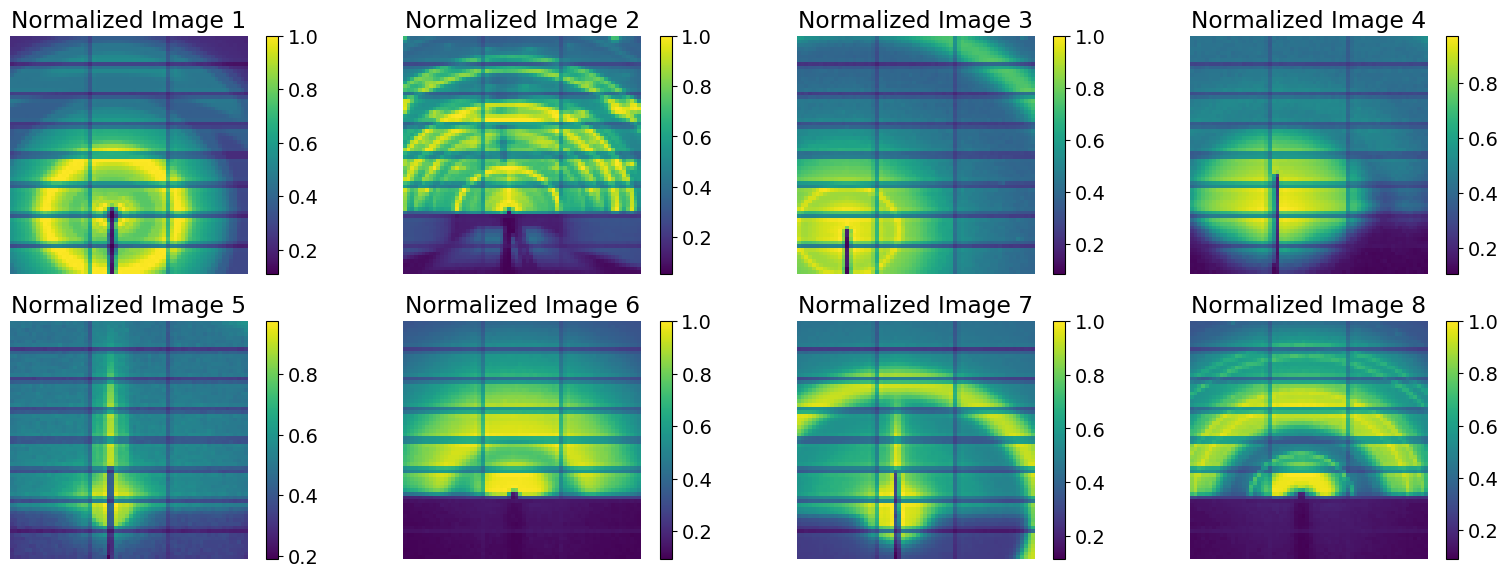

In [5]:
images = torch.tensor(images)
images_norm = min_max_normalize(images)


plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 14})  # Change fontsize
for j in range(0, 8):
    plt.subplot(2, 4, j + 1)  # Create a 2x5 grid of subplots
    plt.imshow(images_norm[j])
    plt.colorbar()
    plt.title(f"Normalized Image {j + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

<hr style="height:2px;border-width:0;color:black;background-color:black">

## 1.3.3 Principal Component Analysis: Linear Reduction

**Principal Component Analysis (PCA)** is a fundamental technique in the field of dimensionality reduction. 

By identifying the principal components -- the set orthogonal vectors capturing the maximum variance in the data -- PCA enables a compact representation of information while preserving its essential characteristics. PCA is used to transform high-dimensional data into a new, typically two-dimensional coordinate system; i.e. each 64x64 pixel image is compressed into a set of two or more real numbers.

Why reduce dimensionality?

- Aids in visualizing complex data.
- Store compressed representations of data.
- Enhances computational efficiency in various machine learning and statistical analysis tasks. 
- Overall simplifies data analysis and pattern recognition tasks.

## 1.3.3.1  PCA with 2 Principal Components

Below, let's write a function to apply PCA to out image stack using the widely-used [scikit-learn machine learning library](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [6]:
from sklearn.decomposition import PCA

def perform_PCA(imgs, n_components=2):
    """ 
    This function applies the built-in PCA algorithm from
    scikit-learn and returns:
    
        1) pca:        the pca transformation
        2) pca_result: the dimensionally reduced result
    """
    # Reshape the image stack to prepare for PCA
    reshaped_images = imgs.reshape(imgs.shape[0], -1)  # squashes all dims after 0th index

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(reshaped_images)

    return pca, pca_result


Resulting dimensions/shape of PCA output on raw data:  (400, 2)



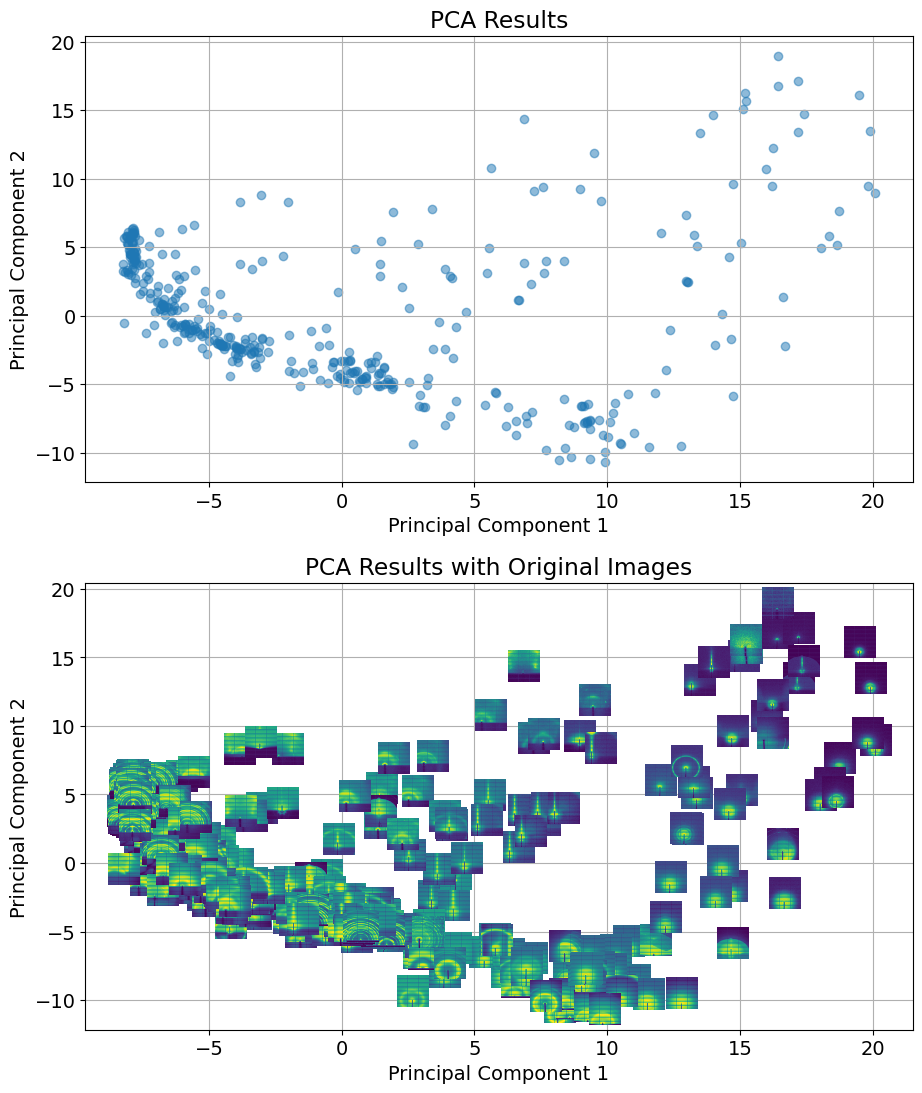

In [7]:
pca_transformation, images_pca = perform_PCA(images_norm)

print('Resulting dimensions/shape of PCA output on raw data: ', images_pca.shape)
print('')

plot_reduction(images_pca, images_norm, category='PCA')

### 1.3.3.1a Use case: PCA applied to grazing incident small x-ray scattering (GISAXS) data

[Liu, Shuai, et al](https://link.springer.com/content/pdf/10.1557/mrc.2019.26.pdf) use deep neural network to predict seven combinations of 3d nanoparticle lattice orientations form experimental data, then apply PCA to visualize the predicted image categorization.

**Pros:**
- Great for visualization and qualitative analysis
    - Clear separation for FCC (face-centered cubic)
    
**Cons:**
- May result in a lot of overlap
    - "First two components only contribute %65 of explained variance... overlapping might be separated in higher dimensional space."
    
<img src="https://static.cambridge.org/content/id/urn%3Acambridge.org%3Aid%3Aarticle%3AS2159685919000260/resource/name/S2159685919000260_figAb.jpeg" width=500/>

## 1.3.3.2 Image Reconstruction With PCA

We can also use PCA to reconstruct the original image from the dimensionally reduced projection.

- Once `pca_transformation.fit_transform` has compressed the data, apply **`pca_transformation.inverse_transform`**
    - Note: this requires liberal use of numpy/torch `reshape` function.
- Advantages:
    - Instead of saving the original 400x64x64 dataset, only the PCA transformation object and the 400x2 compressed data need to be saved.

In [8]:
reshaped_images     = images_norm.reshape(images_norm.shape[0],-1)
images_compressed   = pca_transformation.fit_transform(reshaped_images)
images_decompressed = pca_transformation.inverse_transform(images_compressed).reshape(400,64,64)

print('Shape of original images:     ', images_norm.shape)
print('Shape of compressed images:   ', images_compressed.shape)
print('Shape of decompressed images: ', images_decompressed.shape)

Shape of original images:      torch.Size([400, 64, 64])
Shape of compressed images:    (400, 2)
Shape of decompressed images:  (400, 64, 64)


PCA reconstruction of image 0


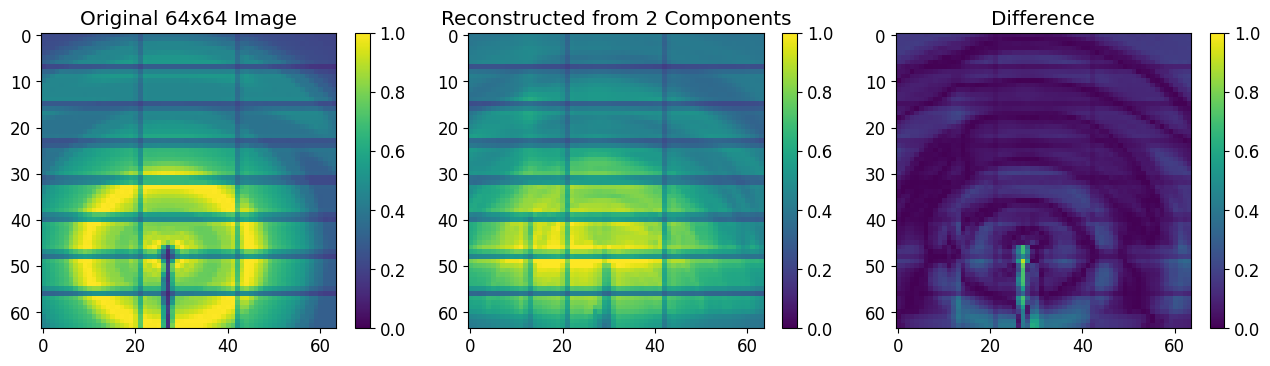

PCA reconstruction of image 1


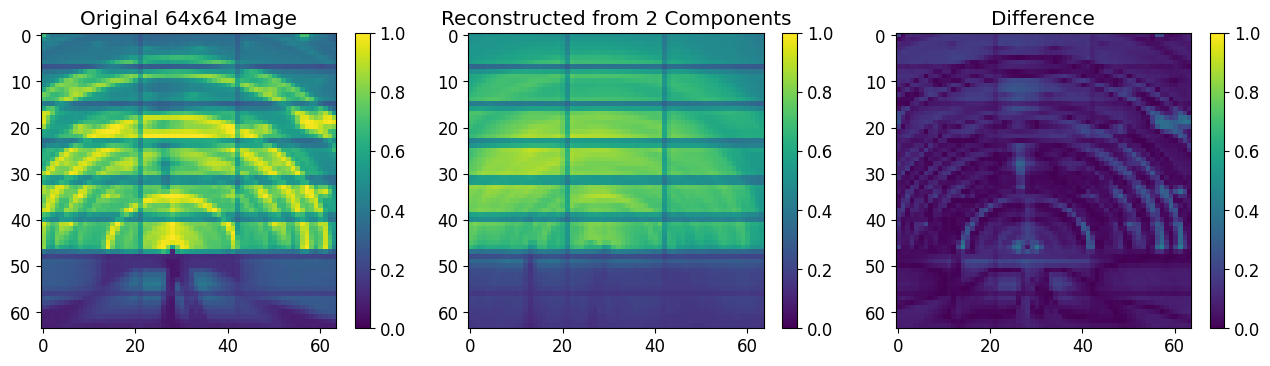

PCA reconstruction of image 2


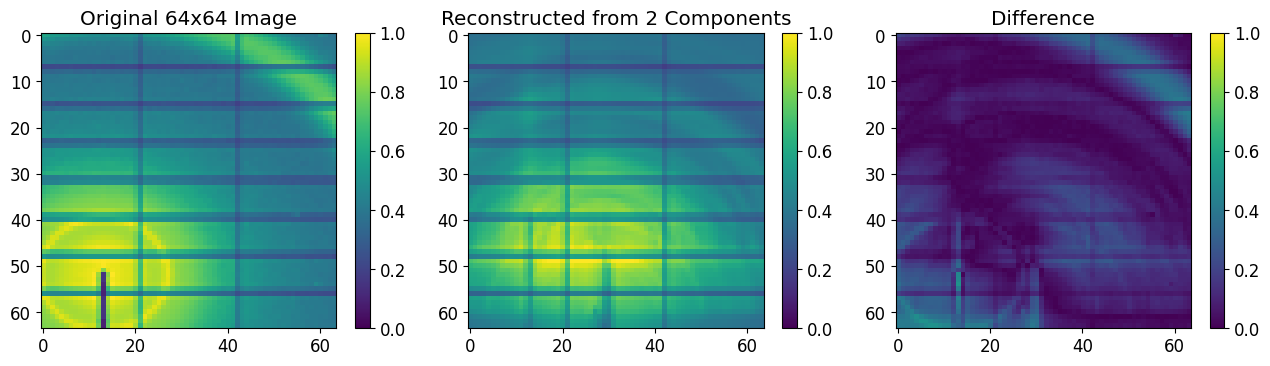

In [9]:
image_index = [0, 1, 2]

for j in image_index:
    print('PCA reconstruction of image ' + str(j))
    img = images_norm[j]
    img_recon = images_decompressed[j]
    plot_reconstruction(img, img_recon, num_components = 2)

## 1.3.3.2 PCA with More Principal Components

Let's now reduce dimensionality down to 12 principal components instead of 2. How to do this?

- scikit-learn PCA allows us to specify the parameter **`n_components`**.
    - We simply pass along the integer number of components.

In [10]:
pca_transformation12, images_pca12 = perform_PCA(images_norm, n_components=12)

images_decompressed12 = pca_transformation12.inverse_transform(images_pca12).reshape(400,64,64)

print('Resulting dimensions/shape of 12d PCA output on raw data: ', images_pca12.shape)

Resulting dimensions/shape of 12d PCA output on raw data:  (400, 12)


PCA reconstruction of image 0


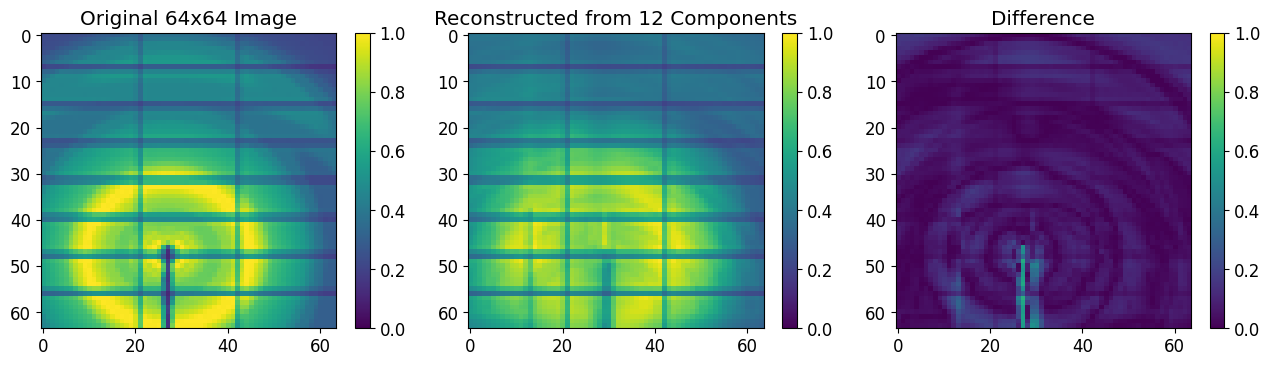

PCA reconstruction of image 1


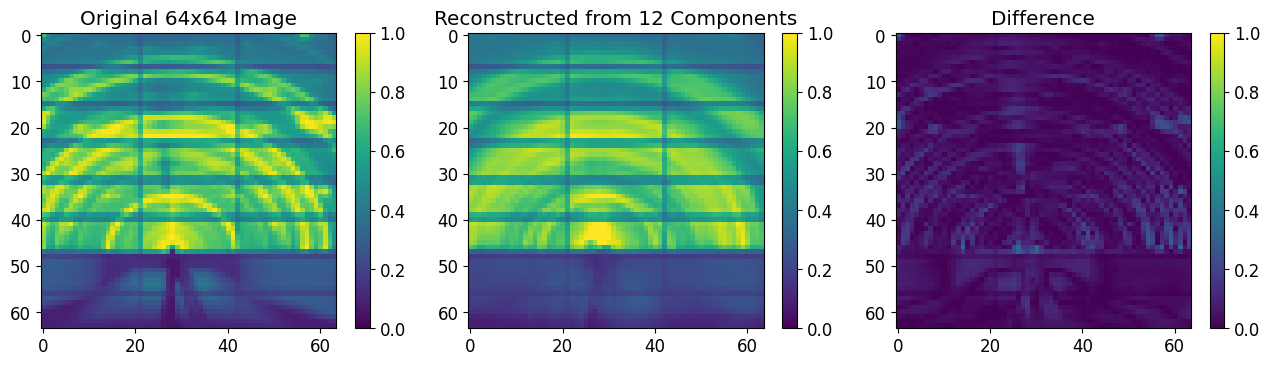

PCA reconstruction of image 2


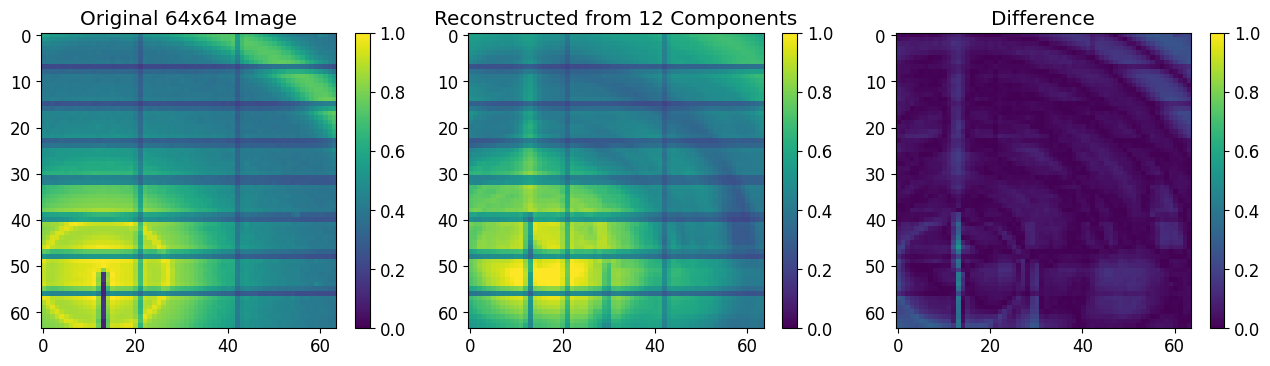

In [11]:
for j in image_index:
    print('PCA reconstruction of image ' + str(j))
    img = images_norm[j]
    img_recon = images_decompressed12[j]
    plot_reconstruction(img, img_recon, num_components = 12)

## 1.3.3.3 How Good Was PCA: Explained Variance

The lower-dimensional representations above can a bit hit-or-miss...

To get more *quantitative*, the PCA's **explained variance** is a measure how how much of the dataset's variance can be attributed to each of the principal components.

- We simply check the `pca_transformation.explained_variance_ratio_` attribute of the PCA transformation.
    - Checking the **explained variance** in the two-dimensional PCA transformation we performed above, we see that **~41%** and **~22%** are attributed to components 1 and 2, respectively.
    - Performing a 12-component PCA below, we plot each components' individual explained variance.


In [12]:
explained_variance = pca_transformation.explained_variance_ratio_

print('Explained variance in Principal Component 1: ', np.round(explained_variance[0], 4))
print('Explained variance in Principal Component 2: ', np.round(explained_variance[1], 4))

Explained variance in Principal Component 1:  0.4104
Explained variance in Principal Component 2:  0.2152


Total explained variance summing along all 12 components:  0.8989493170363815


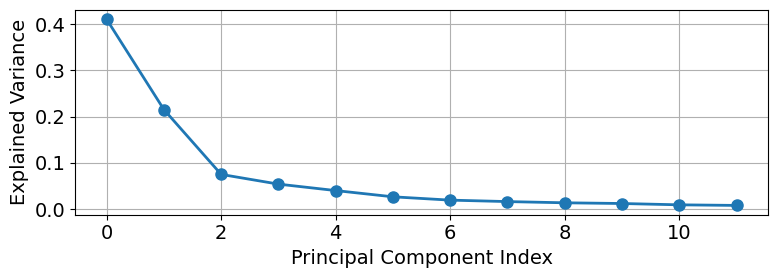

In [13]:
#pca_transformation12, images_pca12 = perform_PCA(images_norm, n_components=12)

explained_variance = pca_transformation12.explained_variance_ratio_

print('Total explained variance summing along all 12 components: ', np.sum(explained_variance))

plt.figure(figsize=(8, 3))
plt.rcParams.update({'font.size': 14})  # Change fontsize
plt.plot(explained_variance, '-o', linewidth=2, markersize=8)
plt.xlabel('Principal Component Index'); plt.ylabel('Explained Variance')
plt.grid(); plt.tight_layout()
plt.show()

## 1.3.3.4 Principal Component Analysis: Controlling Explained Variance

Instead of **~90%** of the dataset's explained variance in the first 12 principal components, **what if we want to capture **99%**?

- scikit_learn allows us to specify desired variance to be captured by accepting non-integer $$\text{n_components} \in [0, 1).$$

- Controlling for **99%** of explained variance, **we have reduced per-image dimensions by a factor 52**, down from 4096 pixels to 78 principal components.

In [14]:
pca_transformation99, images_pca99 = perform_PCA(images_norm, n_components=.99)
explained_variance = pca_transformation99.explained_variance_ratio_

print('Variance captured by this PCA:  ', np.sum(explained_variance))
print('Number of principal components: ', len(explained_variance))

Variance captured by this PCA:   0.9901021382430525
Number of principal components:  78


PCA reconstruction of image 0


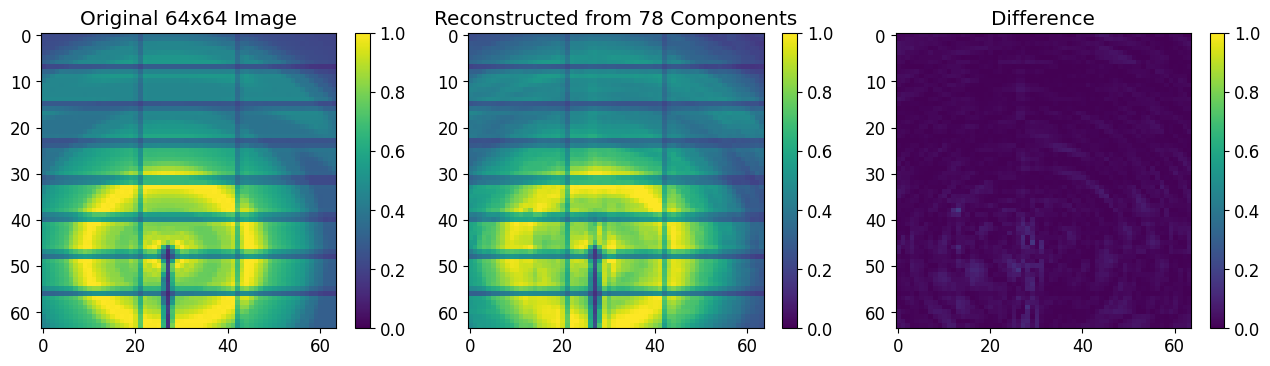

PCA reconstruction of image 1


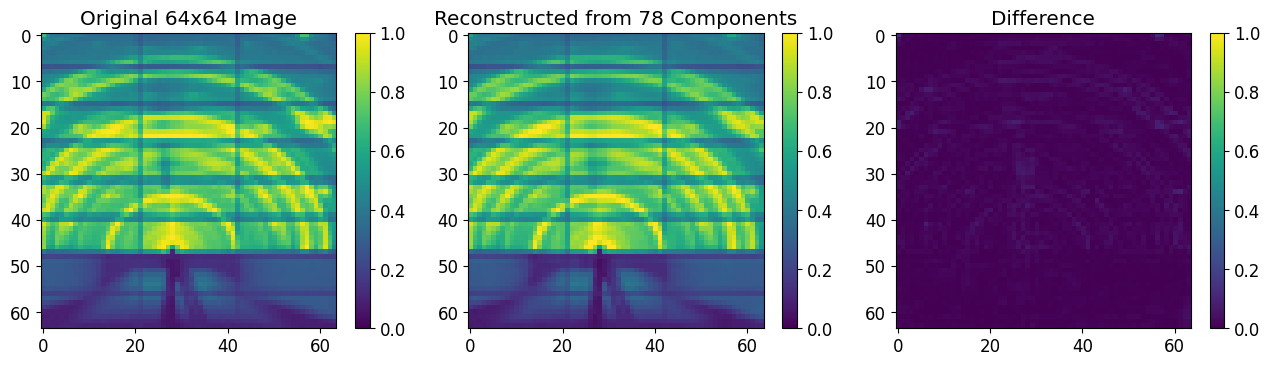

PCA reconstruction of image 2


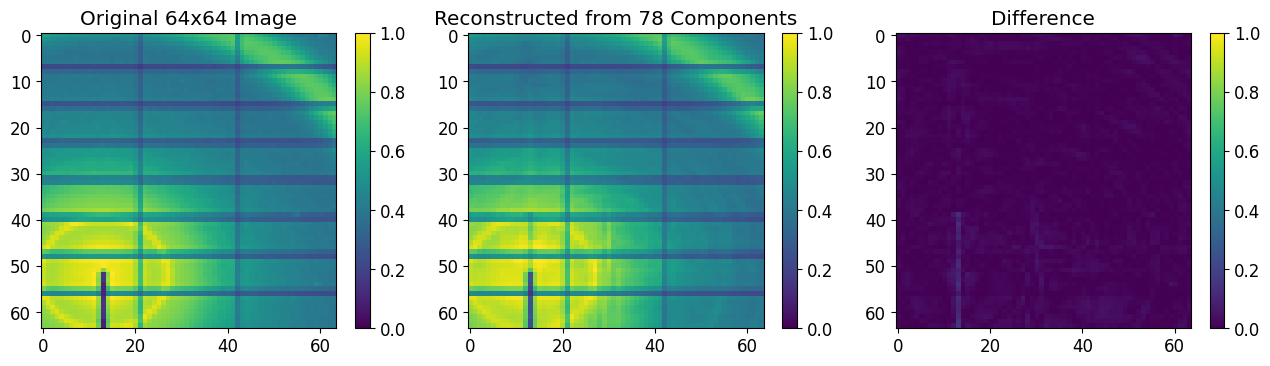

In [15]:
images_decompressed99 = pca_transformation99.inverse_transform(images_pca99).reshape(400,64,64)

for j in image_index:
    print('PCA reconstruction of image ' + str(j))
    img = images_norm[j]
    img_recon = images_decompressed99[j]
    plot_reconstruction(img, img_recon, num_components=len(explained_variance))

## 1.3.3.5 DIY Time

Choose your own images and control your PCA transformation. Simply modify where you see an underscore, namely:

- image_index -- choose images to view
- n_components -- feel free to choose the integer number of components or expected variance

```
image_index = [_ ,_ ,_ ,_ ,_]

my_pca_transformation, my_images_pca = perform_PCA(images_norm, n_components=_)
my_explained_variance = my_pca_transformation.explained_variance_ratio_

print('Variance captured by my PCA:  ', np.sum(my_explained_variance))
print('Number of principal components: ', len(my_explained_variance))
print('')

my_images_decompressed = my_pca_transformation.inverse_transform(my_images_pca).reshape(400,64,64)

for j in image_index:
    print('PCA reconstruction of image ' + str(j))
    img = images_norm[j]
    img_recon = my_images_decompressed[j]
    plot_reconstruction(img, img_recon, num_components=len(my_explained_variance))
```

In [16]:
"""Copy and paste code from cell above"""



'Copy and paste code from cell above'


## 1.3.3.6 (Extra) Saving, Loading, Applying a PCA Transformation

For sake of time, we simply outline the steps for saving & loading and differentiating between fitting PCA to data vs only applying the transformation.

- Can apply our transformation to **new** data using `pca_transformation.transform`
    - As opposed to `pca_transformation.fit_transform` which computes new covariance matrices/eigenvalues, etc.
- Many ways to save sklearn PCA object
    - save to file with `pickle.dump(pca_transformation, open("pca_transformation.pkl","wb"))`
    - load to file with `pca_reload = pickle.load(open("pca_transformation.pkl",'rb'))

<hr style="height:2px;border-width:0;color:black;background-color:black">

## 1.3.4 Uniform Manifold Approximation and Projection (U-MAP)

<img src="https://umap-learn.readthedocs.io/en/latest/_images/logo_large.png" width=600/>

U-Map is another powerful dimensionality reduction and data visualization tool. It seeks to find a low-dimensional embedding/manifold of data that preserves topological structure. Unlike PCA, which is deterministic and assumes **linearity** in the data, U-Map is better at capturing the **non-linear** structure in high dimensional data. For more details, please see the [U-Map paper on arxiv](https://arxiv.org/pdf/1802.03426.pdf).

- Advantages
    - Excels as a general-use tool for visualization and pre-processing for machine learning
        - Example: great for k-means clustering 
        - Better separation than other non-linear reduction algorithms (t-SNE, PACMap,)
    - Considerably faster scalable to massive datasets 
    - Solid mathematical foundation (manifold theory, Reimannian geometry, algebraic topology, etc.)
- Disadvantages
    - Cannot be used for reconstructing from low dimensions
        - PCA is deterministic and linear, thus reversible

Now we call the [U-MAP algorithm](https://umap-learn.readthedocs.io/en/latest/)

In [17]:
!pip -q install umap-learn 
import umap

def perform_umap(imgs, n_neighbors=None, min_dist=None, random_state=None):
        
    # Reshape the image stack to prepare for U-MAP
    reshaped_images = imgs.reshape(imgs.shape[0], -1)

    # Perform U-MAP
    if n_neighbors is None and min_dist is None:
        umap_model = umap.UMAP(n_components=2, 
                               random_state=random_state)
    else:
        umap_model = umap.UMAP(n_components=2, 
                               n_neighbors=n_neighbors,
                               min_dist=min_dist,
                              random_state=random_state)
    umap_result = umap_model.fit_transform(reshaped_images)

    return umap_result

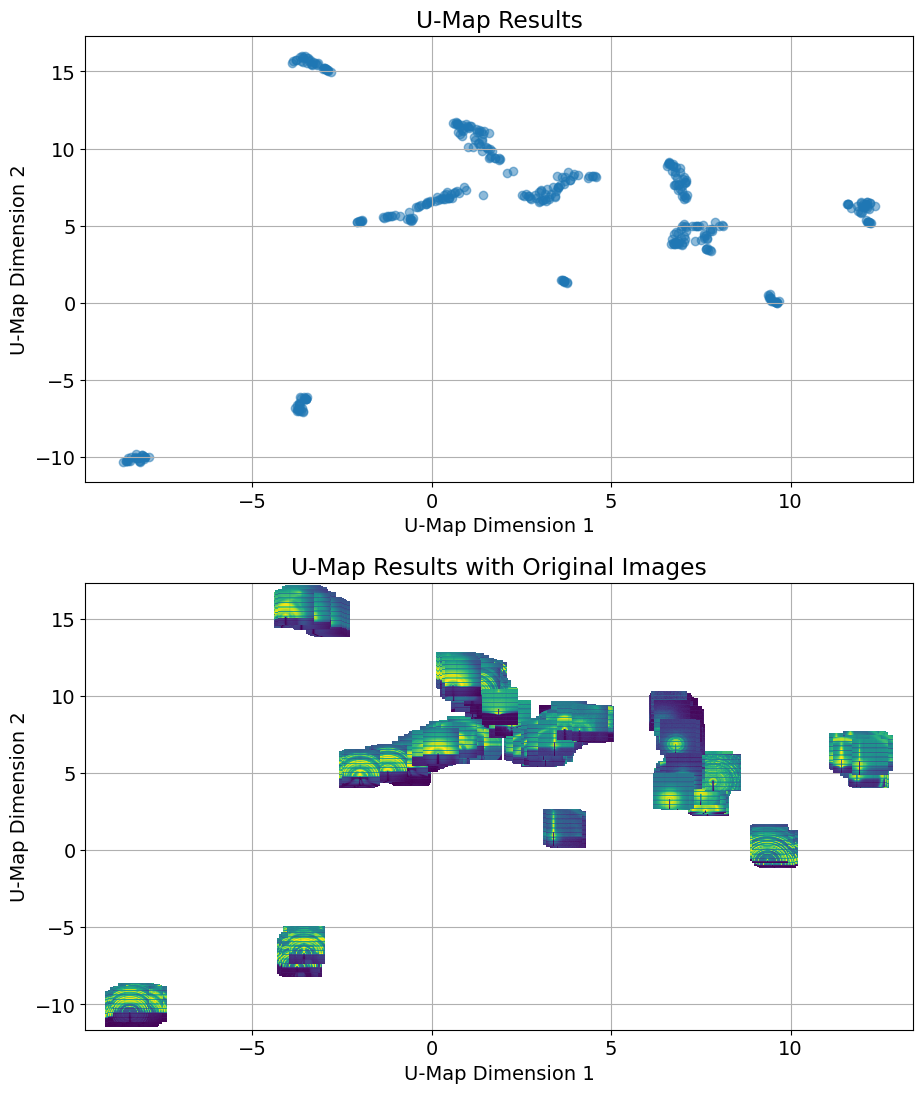

In [18]:
images_umap = perform_umap(images)

plot_reduction(images_umap, images_norm, category='umap', zoom=0.4)

## 1.3.4.1 U-Map Parameters

U-Map has a few parameters to play with, namely:

- n_neighbors -- controls U-Map balance of global vs. local structure in the data when finding best low-dimensional embedding.
    - values may range from 2 (forces a very local view) to half or most of data (more global view) 
    - defaults to 15
- min_dist -- controls how tightly U-Map packs points in the embedding together
    - accepts values between 0.0 and 0.99
    - defaults to 0.1
- n_components -- analogous to PCA principal components
    - defaults to 2, and we will stick with 2d
- random_state -- for reproducabilty, since it's stochastic in nature

/home/ejroberts/anaconda3/envs/dlsia/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


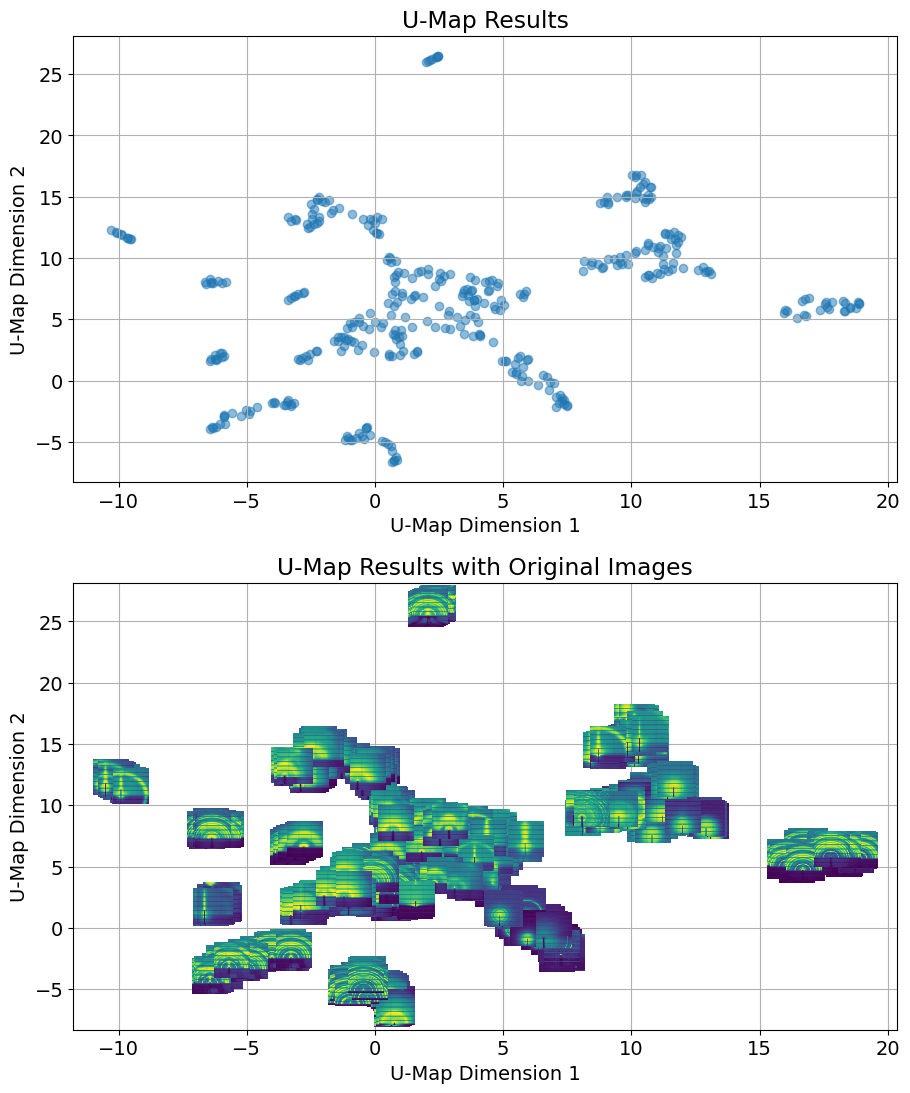

In [19]:
random_state = 2023

images_umap = perform_umap(images,n_neighbors=5, min_dist=0.5, random_state=random_state)

plot_reduction(images_umap, images_norm, category='umap', zoom=0.4)

## 1.3.4.2 DIY Time

Choose your own parameters. Again, modify anywhere you see an underscore and copy & paste the code in the cell below.

```
n_neighbors = _
min_dist = _
random_state = _

images_umap = perform_umap(images,
                           n_neighbors=n_neighbors, 
                           min_dist=min_dist, 
                           random_state=random_state)

plot_reduction(images_umap, category='umap')
plot_umap(images_umap, images_norm)
```

In [20]:
"""Copy and paste code from cell above"""



'Copy and paste code from cell above'

<hr style="height:2px;border-width:0;color:black;background-color:black">

## 1.3.5 Helpful Links

- [PyTorch installation instructions](https://pytorch.org/)
- [dlsia (Deep Learning for Scientific Image Analysis)](https://dlsia.readthedocs.io/en/latest/)
- [scikit-learn for dimensional reductions modules](https://scikit-learn.org/stable/)
- [U-MAP documentation](https://umap-learn.readthedocs.io/en/latest/)
- [U-Map paper and theory](https://arxiv.org/pdf/1802.03426.pdf)